# MAP estimation for Poisson RGG

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../utils')

In [3]:
from graphs import (get_independent_components_rgg, make_inter_vertex_distances, 
                    deg_corrected_poissonian_random_geometric_graph)

In [4]:
from plot import plot_multigraph
from networkx.linalg.graphmatrix import adjacency_matrix
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
from time import time
import pandas as pd
from tqdm import tqdm

In [5]:
import pyro.distributions as dist
import pyro
from torch.distributions import constraints
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import torch
from pyro.infer.autoguide import AutoDelta

In [6]:
SEED = 42
n = 100
dim = 2

## Make synthetic data

In [7]:
lambda_r_truth = 2
exponential_kernel = lambda dist, ki, kj: ki * kj * math.exp(-lambda_r_truth * dist)

In [8]:
g = dist.Exponential(0.1).expand([n])

In [9]:
kolness_truth = g.rsample()

In [10]:
r = np.random.RandomState(SEED)
G_poisson = deg_corrected_poissonian_random_geometric_graph(
    n, 1000, kolness_truth, exponential_kernel, r, 
)

In [11]:
adj = adjacency_matrix(G_poisson)
adj = adj.toarray()

In [12]:
distances = make_inter_vertex_distances(G_poisson)

In [13]:
adj = torch.tensor(adj)
distances = torch.tensor(distances)

## Do MAP estimation

In [14]:
def dc_poisson_rgg_model(distances, adj):
    n_nodes = adj.shape[0]
    k = pyro.sample("kolness", dist.Exponential(0.1).expand([n_nodes]).to_event(1))  # tell pyro that these are all dependent variables
    lambda_r = pyro.sample("lambda_r", dist.Exponential(0.1))
    conn_kernel = torch.exp(-lambda_r*distances)
    
    r, c = torch.triu_indices(n_nodes, n_nodes, offset=1)    
    
    for i in pyro.plate("data_loop", len(r)):
        rate_i = k[r[i]]*k[c[i]]*conn_kernel[r[i],c[i]]
        pyro.sample(f"obs_{i}", dist.Poisson(rate_i), obs=adj[r[i],c[i]]) 

In [15]:
dc_poisson_rgg_guide_map = AutoDelta(dc_poisson_rgg_model)

In [16]:
def train(model, guide, data, lr=0.01, n_steps=100, mode = 'w', losses = None, svi = None):
    if mode == 'w':
        pyro.clear_param_store()
        adam = pyro.optim.Adam({"lr": lr})
        svi = SVI(model, guide, adam, loss=Trace_ELBO())
    
        losses = []
    elif mode != 'a':        
        raise ValueError('mode must be in ("w")')
        
    for step in tqdm(range(n_steps)):
        loss = svi.step(**data)
        losses.append(loss)        
    
    if mode == 'w':
        return losses, svi

In [17]:
data = {'distances':distances, 'adj': adj}

In [18]:
losses, svi = train(dc_poisson_rgg_model, dc_poisson_rgg_guide_map, data, n_steps=100)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:18<00:00,  1.99s/it]


In [58]:
train(dc_poisson_rgg_model, dc_poisson_rgg_guide_map, data, n_steps=40, mode='a', losses=losses, svi=svi)

100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:22<00:00,  2.07s/it]


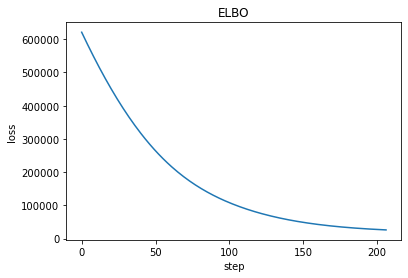

In [59]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_title("ELBO")
ax.set_xlabel("step")
ax.set_ylabel("loss");

In [60]:
map_estimate = pd.DataFrame(zip(pyro.param('AutoDelta.kolness').tolist(), np.array(kolness_truth)), columns=['MAP', 'truth'])

In [61]:
max_k = map_estimate.max().max()
k_sp = np.linspace(0, max_k)

Text(0.5, 1.0, 'Parameter estimation: MAP vs truth')

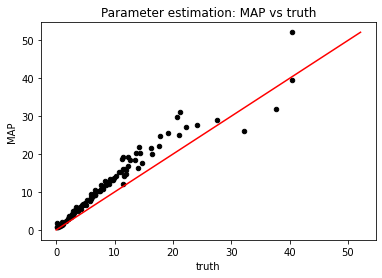

In [62]:
fig, ax = plt.subplots()
map_estimate.plot(x='truth', y='MAP', kind='scatter', ax=ax, color='black')
ax.plot(k_sp, k_sp, '-r');
ax.set_title('Parameter estimation: MAP vs truth')

In [63]:
ranks = pd.DataFrame((map_estimate.MAP.argsort().argsort(), map_estimate.truth.argsort().argsort())).T

Text(0, 0.5, 'Kolness rank (inferred)')

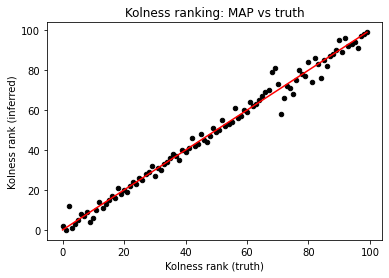

In [65]:
fig, ax = plt.subplots()
ranks.plot(x='truth', y='MAP', kind='scatter', ax=ax, color='black')
ax.plot(range(len(ranks)), range(len(ranks)), '-r');
ax.set_title('Kolness ranking: MAP vs truth')
ax.set_xlabel('Kolness rank (truth)')
ax.set_ylabel('Kolness rank (inferred)')

## Q: Does subsampling preserve ranking?